## Overview

This notebook presents a comparison of two gesture recognition methods: an LSTM classifier and the $1 recognizer by Wobbrock et al. The goal is to assess the performance of these methods on two different types of input:

- Mid-air gestures that were recorded using hand tracking
- Touchpad/mouse gestures, based on the dataset provided by Wobbrock et al.

Both datasets consist of .xml files containing 2D coordinate sequences. All gestures were resampled to a fixed number of points (64 in this case) to ensure equal input length for both methods.

Both the LSTM classifier and the $1 recognizer were evaluated on:

- Accuracy: the precision with which the gestures are classified
- Prediction time: how long it takes to classify a gesture

The complexity of the LSTM classifier was varied by changing the number of hidden units (16, 32, 64). The classifier was trained exclusively on the Wobbrock gesture dataset (excluding the gestures used for the test dataset mentioned above). For details on the training of the LSTM classifier, refer to *lstm.ipynb*.

In [122]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from scipy.signal import resample
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from recognizer import recognize

NUM_POINTS = 64

m1 = '16_units.keras'
m2 = '32_units.keras'
m3 = '64_units.keras'
mid_air_path = '../datasets/test/midair/slow/s01'
wobbrock_path = '../datasets/test/wobbrock/slow/s01'

### Code for determining accuracy and prediction times

In [123]:
# Helpers

# Load an .xml file

def load_xml(filepath, filename):
    tree = ET.parse(filepath)
    root = tree.getroot()

    fname = filename.split('.')[0]
    label = fname[:-2]
    
    points = []
    for point in root.iter('Point'):
        x = float(point.attrib['X'])
        y = float(point.attrib['Y'])
        points.append([x, y])

    points = np.array(points, dtype=float)
                
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    
    resampled = resample(points, NUM_POINTS)

    return resampled, label


# Get prediction times for the LSTM

def get_prediction_time(model, data):
    start = time.time()
    preds = model.predict(data)
    end = time.time()
    total = end - start
    return preds, total, total/len(data) * 1000


# Get accuracy and prediction times for the $1 recognizer

def evaluate_recognizer(folder):
    y_true = []
    y_pred = []

    files = [f for f in os.listdir(folder) if f.endswith(".xml")]
    start = time.time()

    for f in os.listdir(folder):
        points, label = load_xml(os.path.join(folder, f), f)
        pred = recognize(points.tolist())
        y_true.append(label)
        y_pred.append(pred)
    end = time.time()

    total = end - start

    return accuracy_score(y_true, y_pred), total, total/len(files) * 1000

In [124]:
# Preparing the data for prediction with the LSTM

mid_air_data = []
mid_air_labels = []
wobbrock_data = []
wobbrock_labels = []

for f in os.listdir(mid_air_path):
    points, label = load_xml(os.path.join(mid_air_path, f), f)
    mid_air_data.append(points)
    mid_air_labels.append(label)

for f in os.listdir(wobbrock_path):
    points, label = load_xml(os.path.join(wobbrock_path, f), f)
    wobbrock_data.append(points)
    wobbrock_labels.append(label)

    
X_mid_air = np.array(mid_air_data)
X_wobbrock = np.array(wobbrock_data)

encoder = LabelEncoder()
mid_air_encoded = encoder.fit_transform(mid_air_labels)
wobbrock_encoded = encoder.fit_transform(wobbrock_labels)
y_mid_air = to_categorical(mid_air_encoded)
y_wobbrock = to_categorical(wobbrock_encoded)

In [125]:
model_16 = load_model(m1)
model_32 = load_model(m2)
model_64 = load_model(m3)

# Get predictions and prediction times for the LSTM

preds_16_mid, time_16_mid, avg_time_16_mid = get_prediction_time(model_16, X_mid_air)
preds_32_mid, time_32_mid, avg_time_32_mid = get_prediction_time(model_32, X_mid_air)
preds_64_mid, time_64_mid, avg_time_64_mid = get_prediction_time(model_64, X_mid_air)

preds_16_wobbrock, time_16_wobbrock, avg_time_16_wobbrock = get_prediction_time(model_16, X_wobbrock)
preds_32_wobbrock, time_32_wobbrock, avg_time_32_wobbrock = get_prediction_time(model_32, X_wobbrock)
preds_64_wobbrock, time_64_wobbrock, avg_time_64_wobbrock = get_prediction_time(model_64, X_wobbrock)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [126]:
preds_16_mid = np.argmax(preds_16_mid, axis=1)
preds_32_mid = np.argmax(preds_32_mid, axis=1)
preds_64_mid = np.argmax(preds_64_mid, axis=1)
preds_16_wobbrock = np.argmax(preds_16_wobbrock, axis=1)
preds_32_wobbrock = np.argmax(preds_32_wobbrock, axis=1)
preds_64_wobbrock = np.argmax(preds_64_wobbrock, axis=1)

acc_16_mid = accuracy_score(mid_air_encoded, preds_16_mid)
acc_32_mid = accuracy_score(mid_air_encoded, preds_32_mid)
acc_64_mid = accuracy_score(mid_air_encoded, preds_64_mid)
acc_16_wobbrock = accuracy_score(wobbrock_encoded, preds_16_wobbrock)
acc_32_wobbrock = accuracy_score(wobbrock_encoded, preds_32_wobbrock)
acc_64_wobbrock = accuracy_score(wobbrock_encoded, preds_64_wobbrock)

acc_mid_air, time_recognizer_mid, avg_time_recognizer_mid = evaluate_recognizer(mid_air_path)
acc_wobbrock, time_recognizer_wobbrock, avg_time_recognizer_wobbrock = evaluate_recognizer(wobbrock_path)

In [127]:
results = {
    "Model": ["LSTM (16 units)", "LSTM (32units)", "LSTM (64units)", "$1 Recognizer"],
    "Mid-Air Accuracy": [acc_16_mid, acc_32_mid, acc_64_mid, acc_mid_air],
    "Mid-Air Prediction Time (s)": [time_16_mid, time_32_mid, time_64_mid, time_recognizer_mid],
    "Mid-Air Avg Prediction Time (ms)": [avg_time_16_mid, avg_time_32_mid, avg_time_64_mid, avg_time_recognizer_mid],
    "Wobbrock Accuracy": [acc_16_wobbrock, acc_32_wobbrock, acc_64_wobbrock, acc_wobbrock],
    "Wobbrock Prediction Time (s)": [time_16_wobbrock, time_32_wobbrock, time_64_wobbrock, time_recognizer_wobbrock],
    "Wobbrock Avg Prediction Time (ms)": [avg_time_16_wobbrock, avg_time_32_wobbrock, avg_time_64_wobbrock, avg_time_recognizer_wobbrock]
}

df = pd.DataFrame(results)
df = df.round(3)
df

,Model,Mid-Air Accuracy,Mid-Air Prediction Time (s),Mid-Air Avg Prediction Time (ms),Wobbrock Accuracy,Wobbrock Prediction Time (s),Wobbrock Avg Prediction Time (ms)
0,LSTM (16 units),0.84,0.162,3.240,1.0,0.037,0.740
1,LSTM (32units),0.90,0.160,3.200,1.0,0.038,0.760
2,LSTM (64units),0.96,0.161,3.220,1.0,0.040,0.800
3,$1 Recognizer,0.78,0.082,1.644,0.8,0.083,1.652


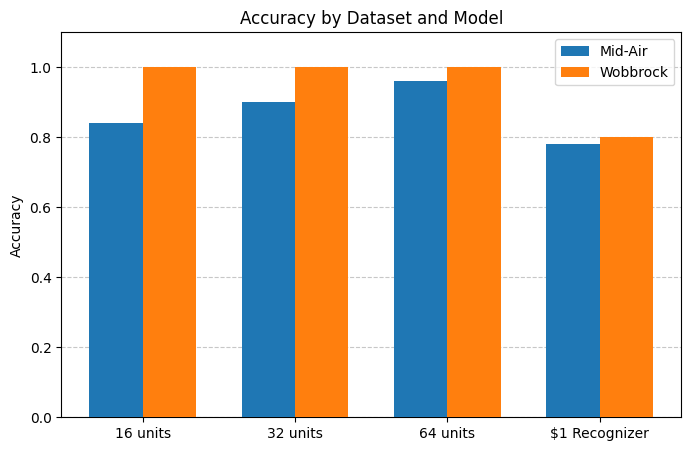

In [128]:
labels = ['16 units', '32 units', '64 units', '$1 Recognizer']
mid_air_acc = [acc_16_mid, acc_32_mid, acc_64_mid, acc_mid_air]
wobbrock_acc = [acc_16_wobbrock, acc_32_wobbrock, acc_64_wobbrock, acc_wobbrock]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bar1 = ax.bar(x - width/2, mid_air_acc, width, label='Mid-Air', zorder=3)
bar2 = ax.bar(x + width/2, wobbrock_acc, width, label='Wobbrock', zorder=3)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Dataset and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.show()

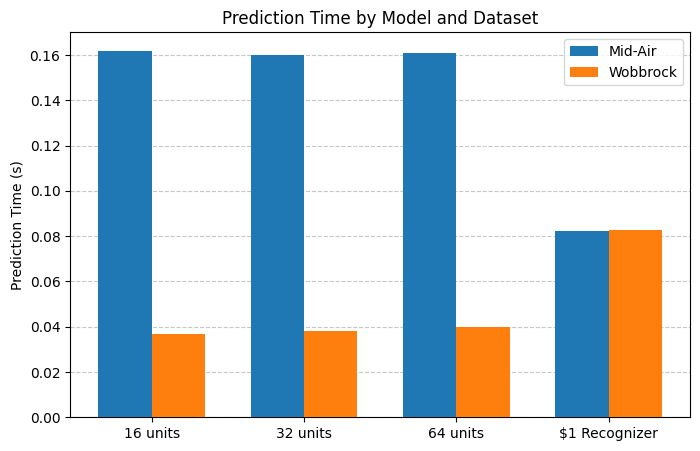

In [129]:
mid_air_times = [time_16_mid, time_32_mid, time_64_mid, time_recognizer_mid]
wobbrock_times = [time_16_wobbrock, time_32_wobbrock, time_64_wobbrock, time_recognizer_wobbrock]

fig, ax = plt.subplots(figsize=(8,5))
bar1 = ax.bar(x - width/2, mid_air_times, width, label='Mid-Air', zorder=3)
bar2 = ax.bar(x + width/2, wobbrock_times, width, label='Wobbrock', zorder=3)

ax.set_ylabel('Prediction Time (s)')
ax.set_title('Prediction Time by Model and Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.show()


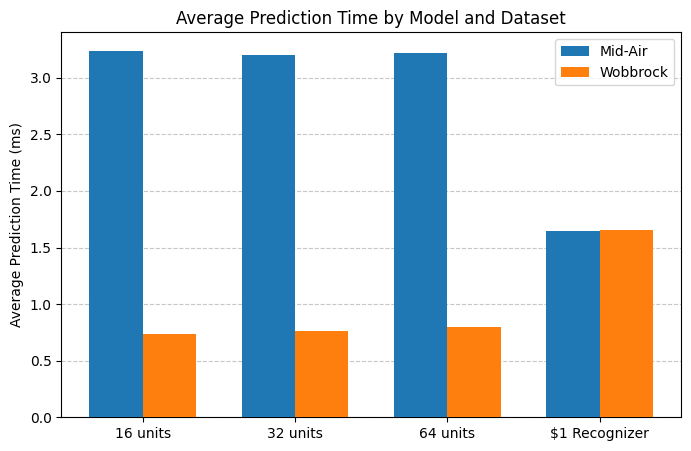

In [130]:
avg_mid_air_times = [avg_time_16_mid, avg_time_32_mid, avg_time_64_mid, avg_time_recognizer_mid]
avg_wobbrock_times = [avg_time_16_wobbrock, avg_time_32_wobbrock, avg_time_64_wobbrock, avg_time_recognizer_wobbrock]

fig, ax = plt.subplots(figsize=(8,5))
bar1 = ax.bar(x - width/2, avg_mid_air_times, width, label='Mid-Air', zorder=3)
bar2 = ax.bar(x + width/2, avg_wobbrock_times, width, label='Wobbrock', zorder=3)

ax.set_ylabel('Average Prediction Time (ms)')
ax.set_title('Average Prediction Time by Model and Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.show()

## Summary of Results

The evaluation compares LSTM models with varying parameter counts (16, 32, and 64 units) against the $1 recognizer on two datasets: mid-air gesture data and Wobbrock et al.'s mouse/touchpad dataset.

### Accuracy
- For the mid-air dataset, the LSTM models achieve accuracies from 84% (16 units) up to 96% (64 units), while the $1 recognizer reaches 78%.
- On the Wobbrock dataset, all LSTM models achieve perfect accuracy (100%), outperforming the $1 recongizer which scores 80%.

### Prediction Time
- The $1 recognizer is consistently faster, with average prediction times around 1.6 ms per sample on both datasets.
- The LSTM models have longer prediction times, ~3.2 ms on the mid-air data and 0.74-0.80 ms on the Wobbrock dataset.

### Trade-offs
- Higher LSTM complexity achieves better accuracy on mid-air gestures but slightly increases prediction time.
- For mouse/touchpad input like Wobbrock's dataset, even the smallest LSTM model achieves perfect accuracy with minimal time differenecs.
- The $1 recognizer offers faster predictions but at a noticeable cost in accuracy, especially on mid-air data.


## Interpretation
The LSTM models handle mid-air gestures better than the $1 recognizer, likely because mid-air gestures are more complex and exhibit greater variability over time. The LSTM's ability to capture these temporal patterns gives it an advantage in terms of accuracy.

For the Wobbrock dataset, which consists of mouse/touchpad gestures, all LSTM models achieve perfect accuracy, suggesting that the task is simpler or the data more consistent. The $1 recognizer is faster but less accurate here, which means it might be suitable for quick, less critical applications.

In terms of prediction speed, the $1 recognizer is faster on both datasets, but considering the LSTM models' improvement in accuracy, the additional time cost of the LSTM is quite small.

Overall, the choice depends on application needs: if prediction speed is critical and slight accuracy loss is acceptable, the $1 recognizer is suitable. For higher accuracy and robustness, LSTM models might be preferable, especially with complex mid-air data.